In this notebook, we will train a simple logistic regression model and package it for use in Matlab. 

In [132]:
import os
import pandas as pd

def combine_csv(folder_path, test_condition):
    """
    Combine all CSV files in a folder into a single DataFrame.
    :param folder_path: Path to the folder containing the CSV files
    :param seq_idx: Sequence index
    :param label: Label of the sequence (Normal - 0, Abnormal - 1)
    :return: A single DataFrame containing all the data from the CSV files
    """

    # Get a list of all CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    # Create an empty DataFrame to store the combined data
    combined_df = pd.DataFrame()

    # Iterate over the CSV files in the folder
    for file in csv_files:
        # Construct the full path to each CSV file
        file_path = os.path.join(folder_path, file)

        # Read each CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Drop the time. Will add later.
        df = df.drop(labels=df.columns[0], axis=1)

        # Extract the file name (excluding the extension) to use as a prefix
        file_name = os.path.splitext(file)[0]

        # Add a prefix to each column based on the file name
        df = df.add_prefix(f'{file_name}_')

        # Concatenate the current DataFrame with the combined DataFrame
        combined_df = pd.concat([combined_df, df], axis=1)

    df = pd.read_csv(file_path)
    combined_df = pd.concat([df['time'], combined_df], axis=1)
    combined_df.loc[:, 'test_condition'] = test_condition

    return combined_df
        

In [133]:
# Read the data
path_training = ['static_with_fault_1', 'static_with_fault_2', 'static_with_fault_3', 
'static_with_fault_4', 'static_with_fault_5', 'static_with_fault_6', 
'steady_state_after_movement', 'steady_state_not_moving'
]

path_test = ['task_fault']

# path_header = '../data_collection/collected_data/'
path_header = os.path.abspath('../data_collection/collected_data/')


df = pd.DataFrame()
for tmp_path in path_training:
    # path = path_header + tmp_path
    path = path_header + '/' + tmp_path
    tmp_df = combine_csv(path, tmp_path)
    df = pd.concat([df, tmp_df])
    df = df.reset_index(drop=True)

df_test = pd.DataFrame()
for tmp_path in path_test:
    # path = path_header + tmp_path
    path = path_header + '/' + tmp_path
    tmp_df = combine_csv(path, tmp_path)
    df_test = pd.concat([df_test, tmp_df])
    df_test = df_test.reset_index(drop=True)

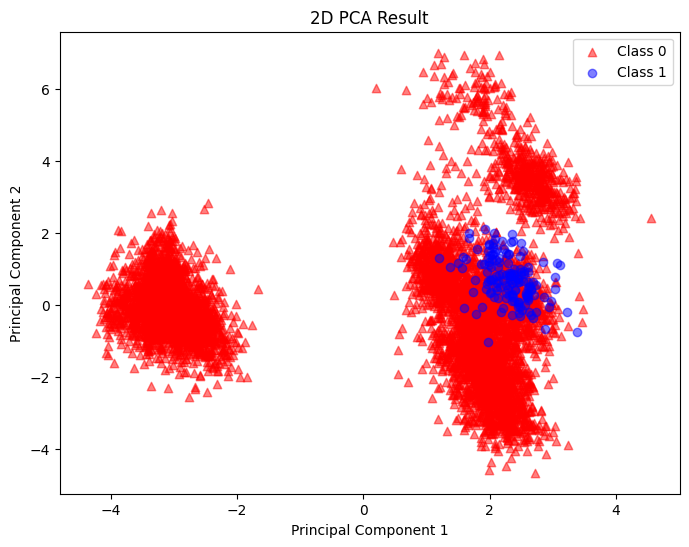

In [134]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_features = ['test_condition', 'time', 'data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label', 
             'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label']
y_feature = 'data_motor_4_label'
# Separate the features (X) and the target variable (y)
X = df.drop(X_features, axis=1)
y = df[y_feature]

X_test_fault = df_test.drop(X_features, axis=1)
y_test_fault = df_test[y_feature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA to reduce the dimensionality to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', marker='^', alpha=.5, label='Class 0')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', marker='o', alpha=.5, label='Class 1')
plt.title('2D PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### Correlation Matrix

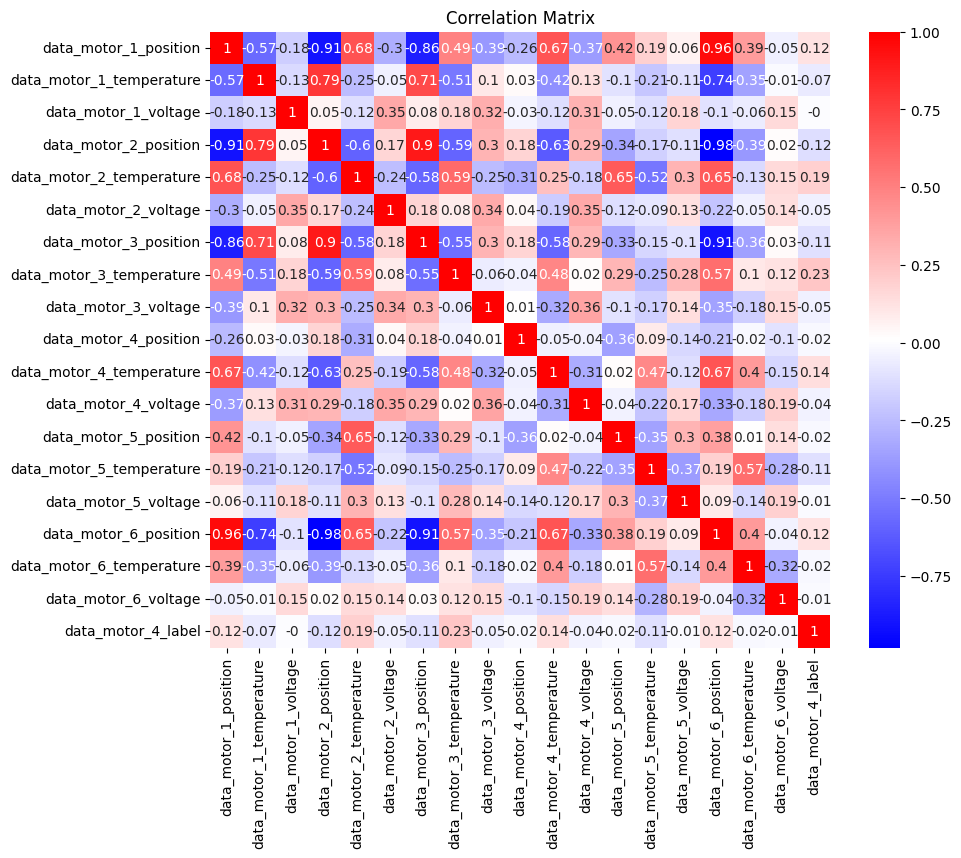

In [135]:
import seaborn as sns

# Concatenate X and y into a single dataframe
df_combined = pd.concat([X, y], axis=1)

# Compute the correlation matrix
corr_matrix = df_combined.corr().round(2)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='bwr')
plt.title('Correlation Matrix')
plt.show()

It looks like the correlation between the X features and the target feature is between -0.21 and +0.23 at best... It's not looking great at first.

### Delete the outliers

In [136]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Standardize the data in X
X_scaled = scaler.fit_transform(X)
X_scaled_test_fault = scaler.fit_transform(X_test_fault)

# Calculate the z-scores for each feature
z_scores = np.abs((X_scaled - X_scaled.mean()) / X_scaled.std())
z_scores_test_fault = np.abs((X_scaled_test_fault - X_scaled_test_fault.mean()) / X_scaled_test_fault.std())

# Define a threshold for outlier detection (e.g., z-score > 3)
threshold = 3

# Identify the indices of outliers
outlier_indices = np.where(z_scores > threshold)[0]
outlier_indices_test_fault = np.where(z_scores_test_fault > threshold)[0]

# Remove the outliers from the dataset
X = X.drop(X.index[outlier_indices])
y = y.drop(y.index[outlier_indices])
X_test_fault = X_test_fault.drop(X_test_fault.index[outlier_indices_test_fault])
y_test_fault = y_test_fault.drop(y_test_fault.index[outlier_indices_test_fault])

### Add the derivative features to the dataset

In [137]:
X_diff = X.diff().fillna(0)
X_diff.columns = [f'{col}_diff' for col in X.columns]
X = pd.concat([X, X_diff], axis=1)

X_test_fault_diff = X_test_fault.diff().fillna(0)
X_test_fault_diff.columns = [f'{col}_diff' for col in X_test_fault.columns]
X_test_fault = pd.concat([X_test_fault, X_test_fault_diff], axis=1)

### Smoothen the dataset

In [138]:
window_size = 10

X_smoothen = X.rolling(window=window_size, min_periods=1).mean()
X = X_smoothen

X_test_fault_smoothen = X_test_fault.rolling(window=window_size, min_periods=1).mean()
X_test_fault = X_test_fault_smoothen

Text(0.5, 1.0, 'Correlation Matrix')

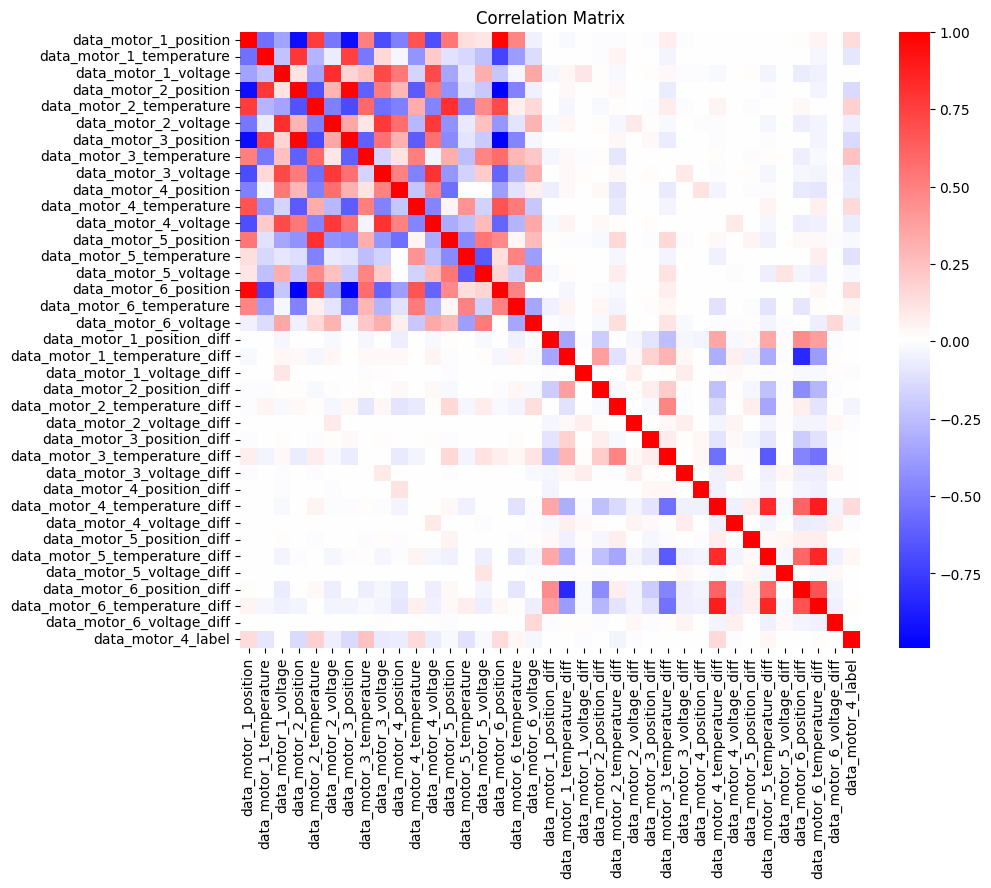

In [139]:
import seaborn as sns

# Concatenate X and y into a single dataframe
df_combined = pd.concat([X, y], axis=1)

# Compute the correlation matrix
corr_matrix = df_combined.corr().round(2)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='bwr')
plt.title('Correlation Matrix')


In [140]:
X

,data_motor_1_position,data_motor_1_temperature,data_motor_1_voltage,data_motor_2_position,data_motor_2_temperature,data_motor_2_voltage,data_motor_3_position,data_motor_3_temperature,data_motor_3_voltage,data_motor_4_position,...,data_motor_3_voltage_diff,data_motor_4_position_diff,data_motor_4_temperature_diff,data_motor_4_voltage_diff,data_motor_5_position_diff,data_motor_5_temperature_diff,data_motor_5_voltage_diff,data_motor_6_position_diff,data_motor_6_temperature_diff,data_motor_6_voltage_diff
1,489.0,50.0,7053.00,501.000000,34.0,7159.00,500.0,29.0,7166.000000,501.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,489.0,50.0,7055.00,501.500000,34.0,7162.50,500.0,29.0,7180.500000,501.0,...,14.500000,0.0,0.0,-12.500000,-0.5,0.0,-13.5,0.0,0.0,-8.500000
3,489.0,50.0,7060.00,501.666667,34.0,7162.00,500.0,29.0,7187.333333,501.0,...,11.666667,0.0,0.0,-8.333333,0.0,0.0,-9.0,0.0,0.0,1.666667
4,489.0,50.0,7063.25,501.750000,34.0,7167.25,500.0,29.0,7183.000000,501.0,...,1.000000,0.0,0.0,6.000000,-0.5,0.0,-0.5,0.0,0.0,-3.750000
5,489.0,50.0,7064.60,501.800000,34.0,7168.80,500.0,29.0,7183.600000,501.0,...,4.000000,0.0,0.0,1.800000,-0.2,0.0,-6.6,0.0,0.0,-4.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6504,488.9,51.0,7132.90,501.000000,30.0,7226.90,500.1,29.0,7235.600000,501.2,...,-2.700000,0.0,0.0,1.300000,0.0,0.0,-0.9,0.0,0.0,1.500000
6505,488.9,51.0,7142.00,501.000000,30.0,7227.40,500.1,29.0,7236.900000,501.3,...,1.300000,0.1,0.0,0.000000,0.0,0.0,2.4,0.0,0.0,7.800000
6506,488.9,51.0,7139.50,501.000000,30.0,7228.10,500.2,29.0,7236.000000,501.3,...,-0.900000,0.0,0.0,1.400000,0.0,0.0,1.8,0.0,0.0,-3.100000
6507,488.9,51.0,7140.10,501.000000,30.0,7228.70,500.2,29.0,7236.500000,501.3,...,0.500000,0.0,0.0,-0.700000,0.0,0.0,-0.4,0.0,0.0,-0.200000


In [141]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import joblib
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category = ConvergenceWarning)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with Standardization and Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

# Define hyperparameters for grid search
param_grid = {'classifier__C': np.logspace(-1, 1, 5)}

# Use GridSearchCV to find the best hyperparameters and fit the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Use grid_search.predict to make predictions on the testing dataset
y_pred = grid_search.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Compute precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Compute recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Save the best model from grid search
best_model = grid_search.best_estimator_

joblib.dump(best_model, 'best_model_LR.model')


Confusion Matrix:
[[1111   21]
 [   1   27]]
Accuracy: 0.9810344827586207
Precision: 0.5625
Recall: 0.9642857142857143
F1 Score: 0.7105263157894737


['best_model_LR.model']

<Axes: >

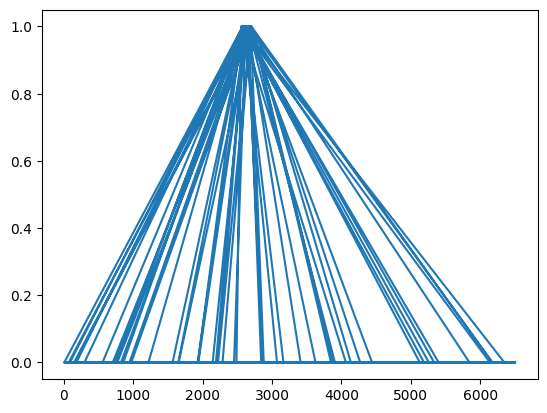

In [151]:
df_result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_result['Actual'].plot()

In [142]:
model = joblib.load('best_model_LR.model')

# Use the loaded model to make predictions on the test data
y_pred_fault = model.predict(X_test_fault)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_fault, y_pred_fault)
print("Confusion Matrix:")
print(conf_matrix)

# Compute accuracy
accuracy = accuracy_score(y_test_fault, y_pred_fault)
print(f"Accuracy: {accuracy}")

# Compute precision
precision = precision_score(y_test_fault, y_pred_fault)
print(f"Precision: {precision}")

# Compute recall
recall = recall_score(y_test_fault, y_pred_fault)
print(f"Recall: {recall}")

# Compute F1 score
f1 = f1_score(y_test_fault, y_pred_fault)
print(f"F1 Score: {f1}")

Confusion Matrix:
[[  0 340]
 [ 14 157]]
Accuracy: 0.30724070450097846
Precision: 0.3158953722334004
Recall: 0.9181286549707602
F1 Score: 0.470059880239521


Can you try to train on the training dataset, except for the "task_fault"? And you test on "task_fault" only?

<Axes: >

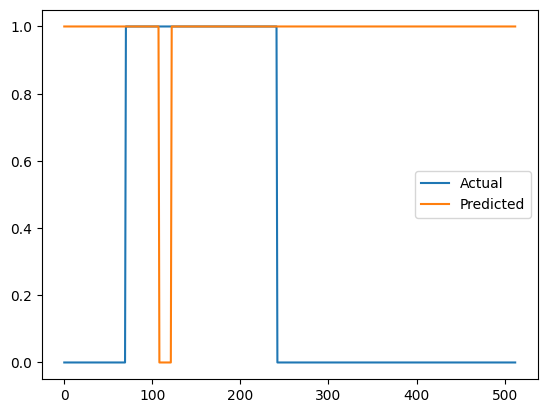

In [145]:
df_result = pd.DataFrame({'Actual': y_test_fault, 'Predicted': y_pred_fault})
df_result.plot()